# Intro
This notebook analyzes CNN verification model performance. Unlike OCSVM and Catboost models, 
it is run directly on image pairs. 
Requriements: test image data and metdata in numpy form, produced by cnn/train.py script.

In [125]:
import sys
sys.path.insert(0, '../../')
import os
import pandas as pd
import cv2
from sklearn.metrics import classification_report
import numpy as np
import glob
import random
from machine_learning.cnn import create_model
from tensorflow.python.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
import matplotlib
%matplotlib notebook
matplotlib.style.use('default')
matplotlib.rcParams['figure.figsize']=[10,6]
pd.options.display.width = 0
pd.set_option('display.max_columns', None)

In [46]:
# load data
x_test = np.load('../../../data/x.npz.test.npz')
x_test = x_test.get(list(x_test.keys())[0])
y_test = np.load('../../../data/y.npz.test.npz')
y_test = y_test.get(list(y_test.keys())[0])
meta = pd.read_csv('../../../data/cnn_meta.csv')

In [47]:
# add fields
meta['filename'] = meta.master.str.extract('^.+/(.+)$')
meta['rend_type'] = meta.filename.str.extract('__[0-9]+__[0-9]+p_(.+)__[0-9]+\.?[0-9]+__[0-9]+')
meta['rend_res'] = meta.filename.str.extract('__[0-9]+__([0-9]+p)')
meta['tamper'] = y_test[..., 1]
meta['tamper_lab'] = meta.tamper > 0.5

In [109]:
meta.groupby('rend_type').rend_type.count().sort_values()

rend_type
watermark_30-24fps                    1
rotate_90_clockwise_25-24fps          1
rotate_90_clockwise_24-60fps          1
vignette_25-60fps                     1
flip_horizontal_30-60fps_gpu          1
flip_horizontal_30-24fps_gpu          1
flip_horizontal_24-60fps_gpu          1
vignette_30-60fps_gpu                 1
black_and_white_25-30fps              1
black_and_white_24-30fps              1
watermark-345x114_25-60fps            1
rotate_90_clockwise_30-24fps          1
watermark-856x856_25-30fps            1
25-60fps_gpu                          1
24-30fps_gpu                          2
rotate_90_clockwise_24-30fps          2
vignette_24-60fps_gpu                 2
25-24fps                              2
25-30fps_gpu                          2
30-24fps                              2
25-24fps_gpu                          3
30-24fps_gpu                          3
24-60fps_gpu                          3
30-60fps_gpu                          3
rotate_90_clockwise_25-24fps_g

In [158]:
# load model
model = create_model()
model.load_weights('../output/verifier_cnn.hdf5')

In [170]:
# predict on test
y_pred = model.predict([x_test[..., 0], x_test[..., 1]])
y_pred_lab = y_pred[..., 1]>0.5

In [171]:
print(classification_report(meta['tamper_lab'], y_pred_lab))

              precision    recall  f1-score   support

       False       0.93      0.92      0.93      1674
        True       0.94      0.95      0.95      2304

    accuracy                           0.94      3978
   macro avg       0.94      0.94      0.94      3978
weighted avg       0.94      0.94      0.94      3978



In [118]:
print('Hardest renditions by type')
hard_rend = meta[y_pred_lab!=meta.tamper_lab].groupby('rend_type').rend_type.count().sort_values().tail(15)
print(hard_rend)

Hardest renditions by type
rend_type
24-60fps_gpu            1
25-24fps_gpu            1
25-60fps_gpu            1
30-24fps_gpu            1
black_and_white         1
vignette                1
24-30fps                2
24-30fps_gpu            2
30-24fps                2
flip_vertical           2
watermark-856x856       2
24-60fps                3
30-60fps                4
rotate_90_clockwise     4
flip_horizontal        23
Name: rend_type, dtype: int64


In [107]:
np.min(x_test)

-1.0

<IPython.core.display.Javascript object>


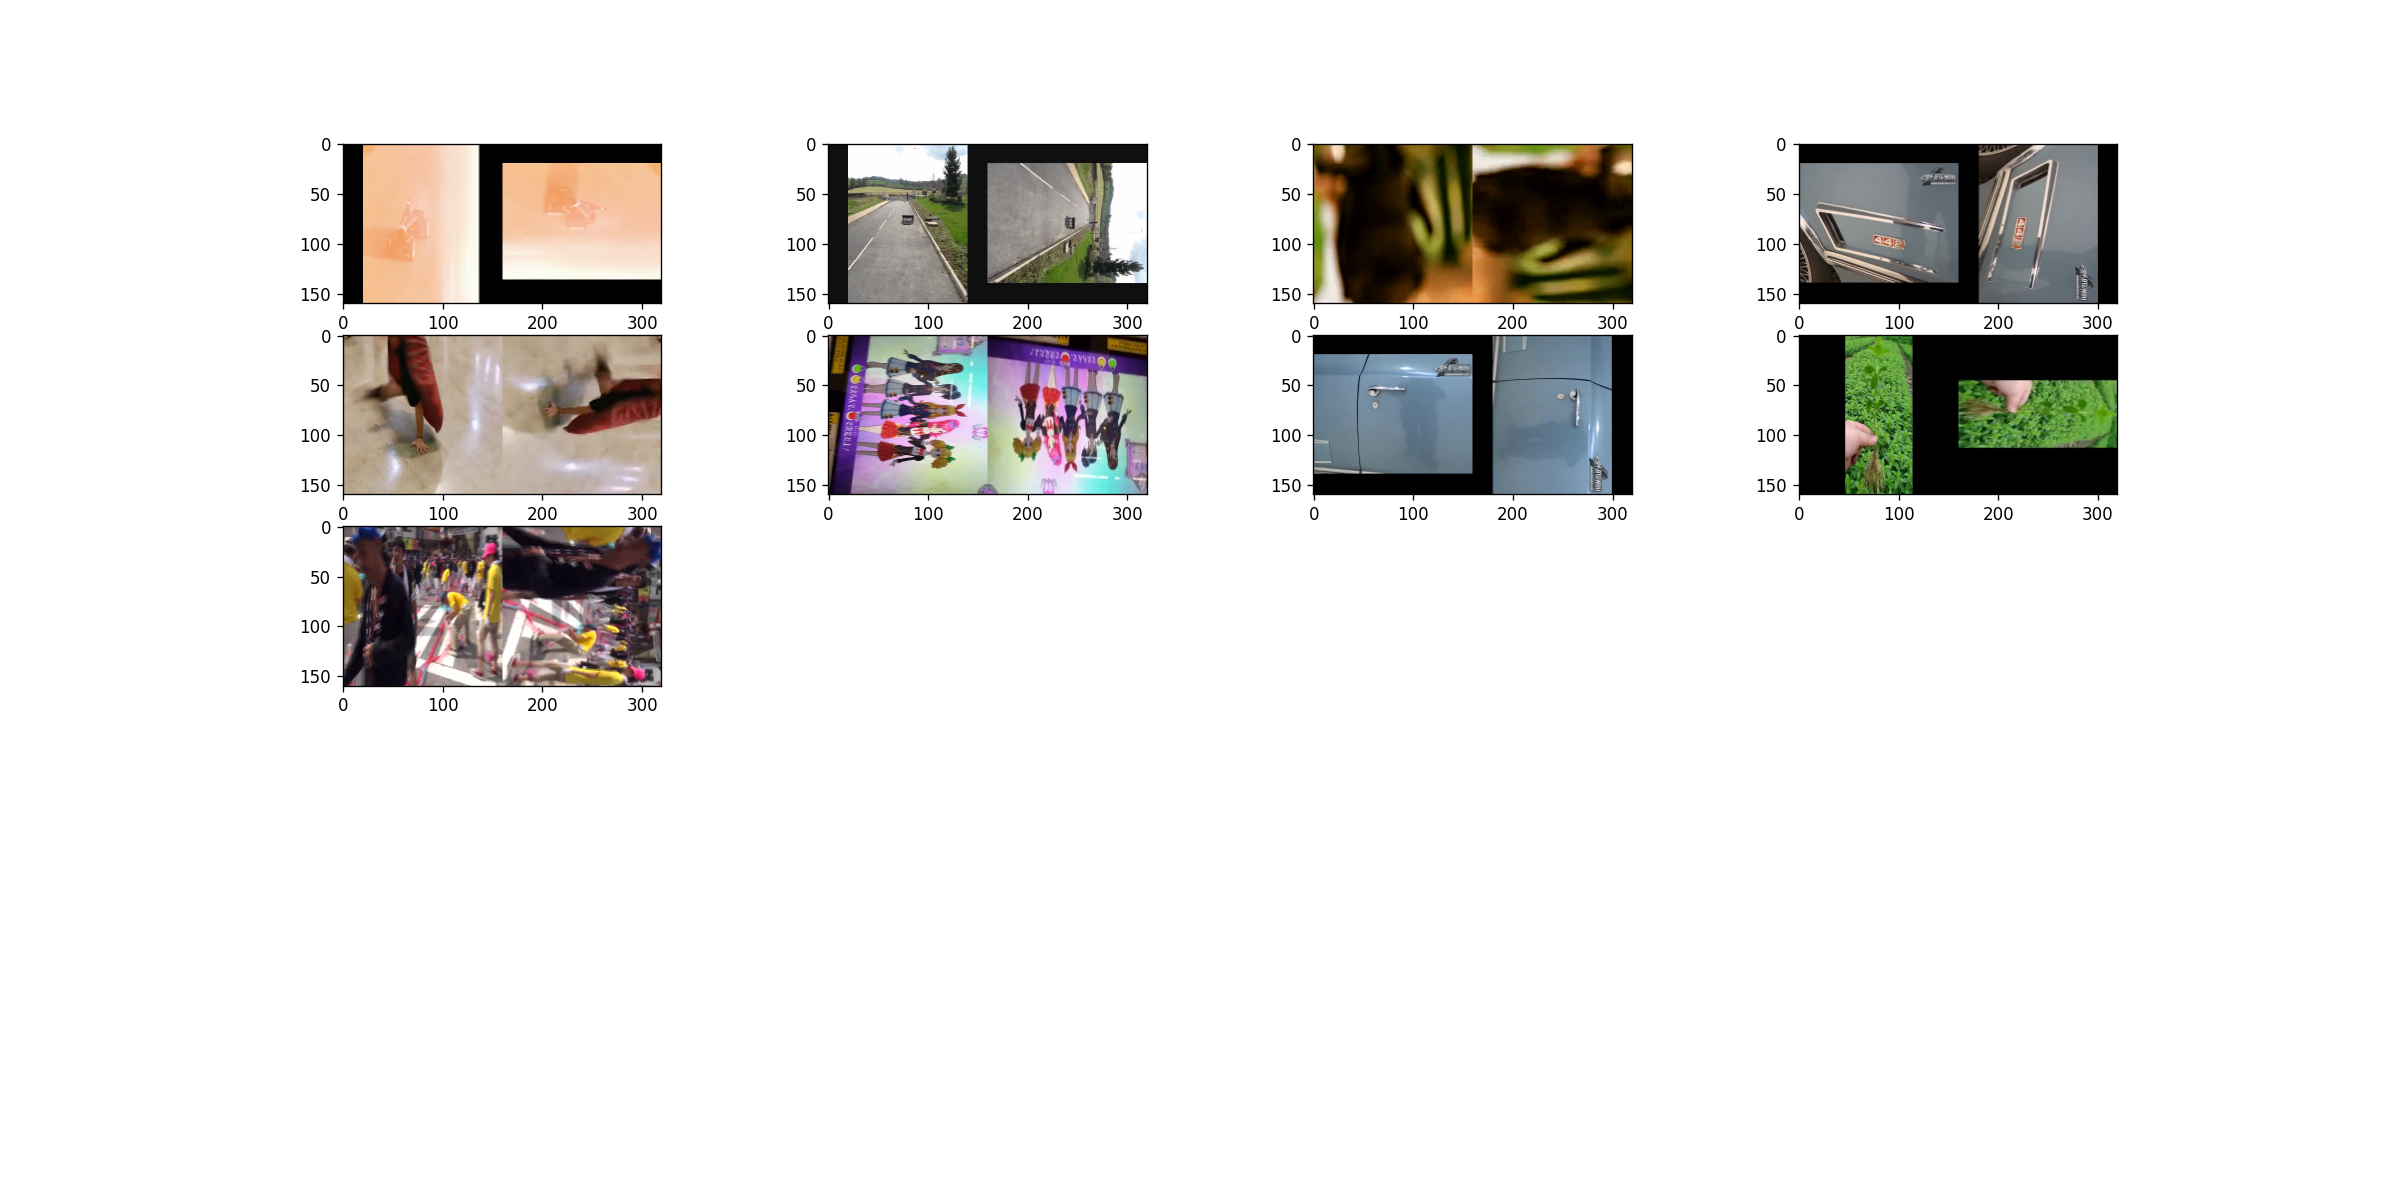

In [112]:
# show some of hardest type samples
hardest_type = hard_rend.index[-1]
hardest_idx = np.where(np.logical_and(y_pred_lab!=meta.tamper_lab, meta.rend_type==hardest_type, y_pred_lab==0))[0]
plt.figure(figsize=(20,10))
columns = 4
n_imgs = 16
hardest_idx = hardest_idx[:n_imgs]
plot_num = 0
for i in hardest_idx:
    image = np.concatenate([x_test[i][...,0], x_test[i][...,1]], axis=1)
    image = ((image+1)*127).astype(np.uint8)
    plt.subplot(n_imgs / columns + 1, columns, plot_num + 1)
    plt.imshow(image)
    plot_num+=1

In [174]:
meta.rend_type.unique()

array(['flip_vertical', 'watermark-345x114', nan, 'vignette', 'watermark',
       'rotate_90_clockwise', '24-60fps', 'watermark-856x856',
       'black_and_white', 'flip_horizontal',
       'flip_horizontal_30-60fps_gpu', '25-30fps_gpu',
       'rotate_90_counterclockwise', 'flip_horizontal_30-24fps_gpu',
       'rotate_90_clockwise_24-60fps', 'watermark-856x856_24-60fps',
       '30-60fps', '25-30fps', '25-24fps', 'watermark_24-60fps_gpu',
       '30-24fps_gpu', 'rotate_90_clockwise_25-60fps', '24-30fps_gpu',
       'watermark-856x856_25-30fps', 'watermark_30-24fps', '25-24fps_gpu',
       'rotate_90_clockwise_24-30fps', '24-60fps_gpu',
       'vignette_24-60fps_gpu', 'rotate_90_clockwise_25-24fps',
       '30-24fps', '24-30fps', 'black_and_white_25-30fps', '25-60fps_gpu',
       '30-60fps_gpu', 'rotate_90_clockwise_30-60fps',
       'rotate_90_clockwise_30-24fps', 'black_and_white_24-30fps',
       'rotate_90_clockwise_25-24fps_gpu', 'flip_horizontal_24-60fps_gpu',
       'vignette_2

<IPython.core.display.Javascript object>


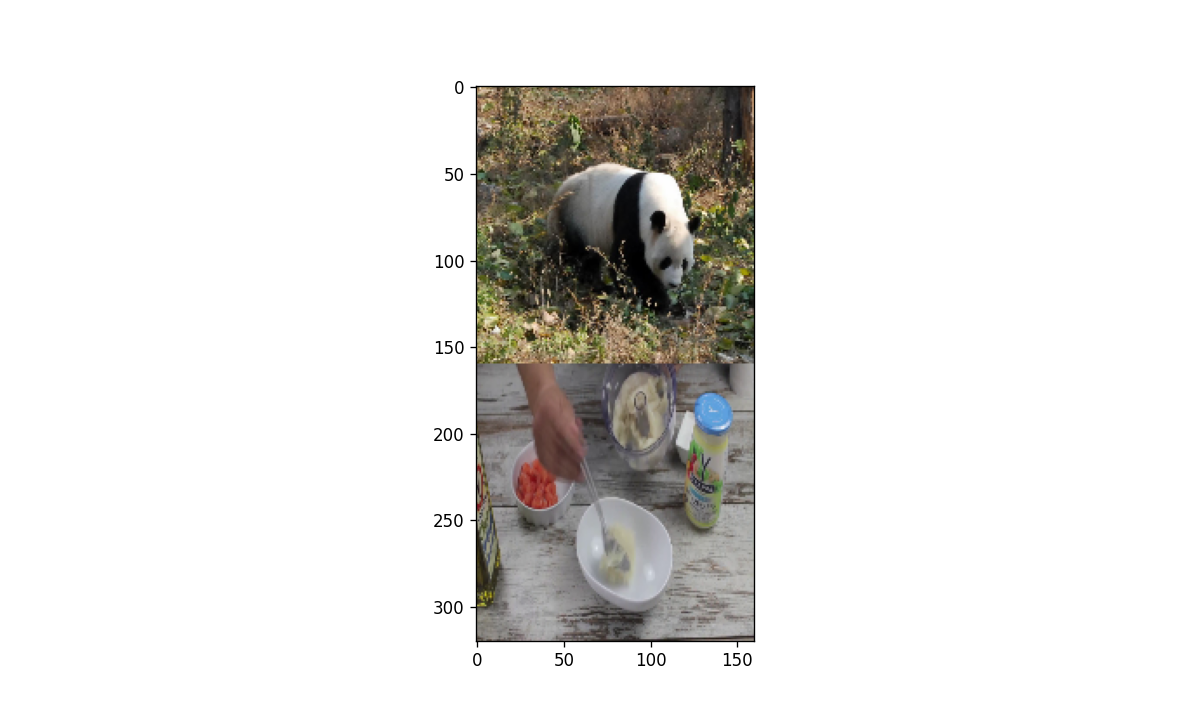

array([0.13046098], dtype=float32)

In [172]:
# check colorspace sample
img1 = cv2.imread('../../testing/tests/data/panda.jpg')[...,::-1]
img2 = cv2.imread('../../testing/tests/data/fix_scene_move_2.png')[...,::-1]
img1 = preprocess_input(img1)
img2 = preprocess_input(img2)
img1 = cv2.resize(img1, (160, 160))
img2 = cv2.resize(img2, (160, 160))
plt.imshow(np.concatenate([((img1+1)*127).astype(np.uint8), ((img2+1)*127).astype(np.uint8)], axis=0))
model.predict([img2[None], img2[None]])[...,1]

(array([  45,  109,  122,  123,  192,  290,  516,  525,  566,  632,  634,
         696,  836,  856,  872,  880,  932,  936,  942,  978, 1001, 1060,
        1093, 1128, 1269, 1279, 1385, 1397, 1403, 1469, 1535, 1609, 1689,
        1822, 2005, 2146, 2323, 2346, 2383, 2387, 2391, 2398, 2442, 2603,
        2625, 2671, 2714, 2768, 2809, 2834, 2891, 2947, 2953, 3008, 3041,
        3215, 3435, 3529, 3568, 3630, 3672, 3691, 3859, 3886, 3901, 3926,
        3947, 3959]),)